# Catalog

In [1]:
import starepandas
import pandas
import geopandas
import matplotlib.pyplot as plt
import sqlalchemy
import shapely
import numpy

## Loading countries
We load the countries of the world and create STARE index values representing their cover. 

In [4]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)
n_america = world[world.continent=='North America']

stare = starepandas.sids_from_gdf(n_america, resolution=7, force_ccw=True)
n_america = starepandas.STAREDataFrame(n_america, sids=stare)

# The trixels are just for visualization
n_america.set_trixels(inplace=True)
n_america.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,sids,trixels
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...","[3035426148847714308, 3062447746611937284, 306...",(POLYGON ((-75.36119395309578 57.6315877704803...
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...","[3332663724254167043, 3071454945866678276, 307...",(POLYGON ((-90.00000034377467 35.2643901689254...
16,10646714,North America,Haiti,HTI,19340.0,"POLYGON ((-71.71236 19.71446, -71.62487 19.169...","[3100869080932941831, 3100904265305030663, 310...",(POLYGON ((-72.49080671672886 19.1339374296424...
17,10734247,North America,Dominican Rep.,DOM,161900.0,"POLYGON ((-71.70830 18.04500, -71.68774 18.316...","[2506253192631681031, 2506323561375858695, 250...",(POLYGON ((-69.40758227230447 18.0684328436267...
19,329988,North America,Bahamas,BHS,9066.0,"MULTIPOLYGON (((-78.98000 26.79000, -78.51000 ...","[3126096275720634375, 3128875841115652103, 313...","(POLYGON ((-77.359038727403 26.6312970536891, ..."


<AxesSubplot:>

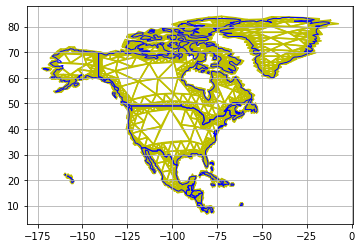

In [5]:
fig, ax = plt.subplots()
ax.grid(True)

n_america.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
n_america.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)

## We are creating a catalogue dataframe

folder2catalogue() scans the path for granules, reads stare cover from the sidecar file as well as the timestamps from the metadata and creatse a catalogue dataframe

In [6]:
folder = '../tests/data/catalog/'
catalog = starepandas.folder2catalog(path=folder, 
                                     granule_extension='hdf',
                                     add_sf=True)
catalog

,granule_path,sidecar_path,stare_cover,begining,ending,geom
0,../tests/data/catalog/MOD05_L2.A2019336.0000.0...,../tests/data/catalog/MOD05_L2.A2019336.0000.0...,"[3614138700964823044, 3616390500778508292, 361...",2019-12-02 00:00:00,2019-12-02 00:05:00,"POLYGON ((-15.93400 53.20178, -15.93275 53.292..."
1,../tests/data/catalog/MOD05_L2.A2005349.2125.0...,../tests/data/catalog/MOD05_L2.A2005349.2125.0...,"[1157425104234217476, 1173187702930014212, 118...",2005-12-15 21:25:00,2005-12-15 21:30:00,"POLYGON ((-171.02278 37.52311, -171.02644 37.4..."
2,../tests/data/catalog/MOD05_L2.A2020254.1320.0...,../tests/data/catalog/MOD05_L2.A2020254.1320.0...,"[2544533789464330244, 2546785589278015492, 256...",2020-09-10 13:20:00,2020-09-10 13:25:00,"POLYGON ((-49.78107 29.28507, -49.78662 29.195..."


## Now we use the catalog to find all granules that intersect our ROI

<AxesSubplot:>

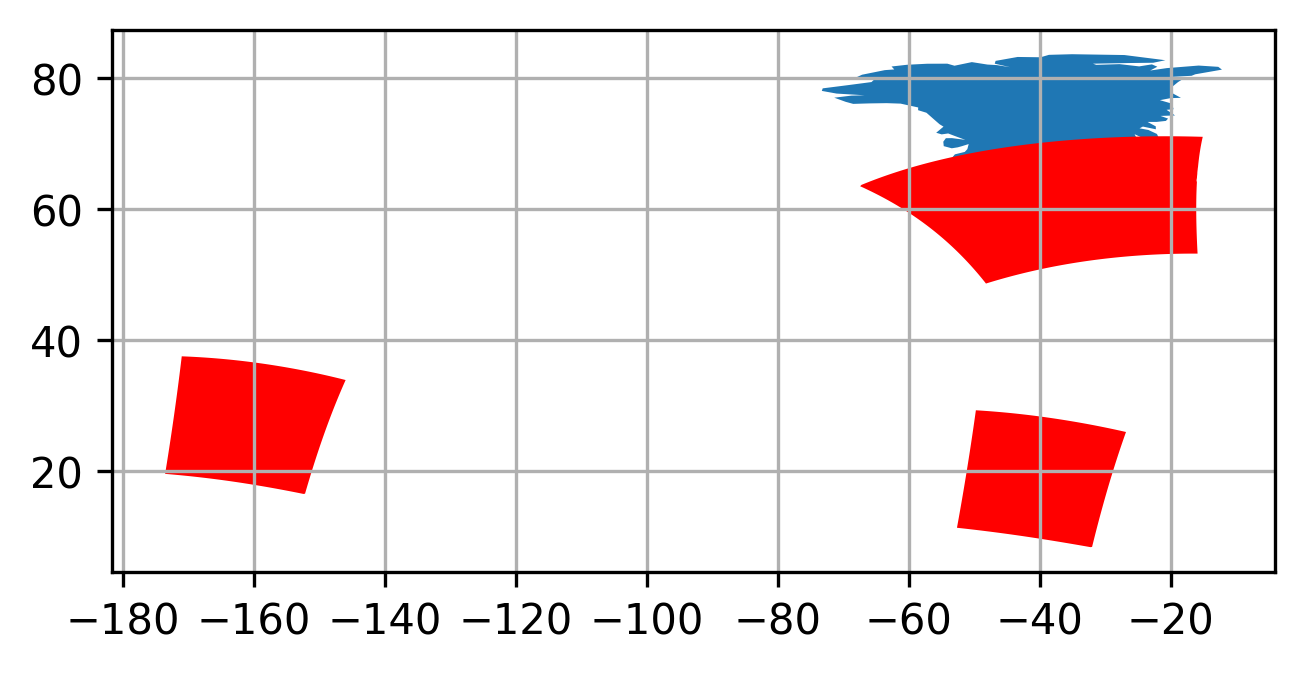

In [5]:
fig, ax = plt.subplots(dpi=300, figsize=(5,5))
ax.grid(True)

country = n_america[n_america.name=='Greenland']
country.plot(ax=ax)
catalog.plot(ax=ax, color='r')

### We can do this with geopandas SF based intersects method

In [7]:
roi_wkt = country.geometry.iloc[0]

cover_intersects = catalog.intersects(roi_wkt)
granule_subset = catalog[cover_intersects].granule_path

granule_subset.head()

2    ../tests/data/catalog/MOD05_L2.A2019336.0000.0...
Name: granule_path, dtype: object

### We can do this with stare_intersects

In [9]:
roi_stare = n_america[n_america.name=='Greenland']['stare'].iloc[0]

cover_intersects = catalog.stare_intersects(roi_stare)
granule_subset = catalog[cover_intersects].granule_path

msg = 'there are {} granules intersecting the ROI'.format(len(granule_subset))
print(msg)
granule_subset.head()

there are 1 granules intersecting the ROI


2    ../tests/data/catalog/MOD05_L2.A2019336.0000.0...
Name: granule_path, dtype: object

## Finally, we extract the data from the pre-selected granules that intersects with our ROI

In [10]:
df = pandas.DataFrame()
for granule in granule_subset:
    g = starepandas.read_granule(granule, sidecar=True)
    intersects = g.stare_intersects(roi_stare)
    msg = '{granule} has {n} intersecting points'.format(granule=granule,
                                                        n=sum(intersects))
    print(msg)
    df = df.append(g[intersects])

../tests/data/catalog/MOD05_L2.A2019336.0000.061.2019336211522.hdf has 26756 intersecting points


In [11]:
df.head()

,stare,Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Water_Vapor_Infrared
55278,3630376560299884459,8.493986e+08,13256,-5505,2864,6766,-9999
55279,3630376364319331947,8.493986e+08,13253,-5518,2910,6757,161
55280,3630446998470491531,8.493986e+08,13249,-5532,2957,6748,166
55546,3630379610335789163,8.493986e+08,13258,-5478,2771,6877,395
55547,3630377324249826827,8.493986e+08,13255,-5491,2817,6867,-9999


## Write to SQL 
We can write the catalogue dataframe to an sql (e.g. sqlite) database. 
From here, we could use STARELite to query the catalogue, or load it back into a STAREDataframe if we need to

In [13]:
db_path = '' # Empty for in-memory
uri = 'sqlite:///{db_path}'.format(db_path=db_path)
engine = sqlalchemy.create_engine(uri)

catalogue_ewkb = geopandas.io.sql._convert_to_ewkb(catalog, 'geom', 4326)
catalogue_ewkb.to_sql(name='catalogue', con=engine, if_exists='replace', index=False)

## Load from SQL

In [14]:
cover_intersects = pandas.read_sql(sql='catalogue', con=engine)

# Geometry and STARE are stored in blobs, so we need to deserialize
cover_intersects.stare_cover = cover_intersects.stare_cover.apply(func=numpy.frombuffer, args=('int64',))
cover_intersects.geom = cover_intersects.geom.apply(shapely.wkb.loads, args=(True,))

# We convert the conventional DF to a STAREDataFrame and set the stare column
cover_intersects = starepandas.STAREDataFrame(cover_intersects, stare='stare_cover')
